In [1]:
import asyncio
from config import *
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.prebuilt import ToolNode

client = MultiServerMCPClient(
    {
        "math": {
            "command": "python",
            # 这里必须换成你的 math_server.py 的绝对路径
            "args": [
                "math_server.py"],
            "transport": "stdio",
        },
        "weather": {
            "url": "http://127.0.0.1:8000/mcp/",
            "transport": "streamable_http",
        },
    }
)

model = ChatOpenAI(model='qwen-plus')
tools = await client.get_tools()

In [2]:
# Bind tools to model
model_with_tools = model.bind_tools(tools)

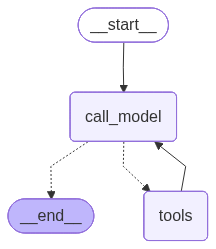

In [3]:
# Create ToolNode
tool_node = ToolNode(tools)


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


# Define call_model function
async def call_model(state: MessagesState):
    messages = state["messages"]
    response = await model_with_tools.ainvoke(messages)
    return {"messages": [response]}


# Build the graph
builder = StateGraph(MessagesState)
builder.add_node("call_model", call_model)
builder.add_node("tools", tool_node)

builder.add_edge(START, "call_model")
builder.add_conditional_edges(
    "call_model",
    should_continue,
    {"tools": "tools", END: END},
)
builder.add_edge("tools", "call_model")

# Compile the graph
graph = builder.compile()

from IPython.display import Image, display

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [4]:
# Test the graph
math_response = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what's (3 + 5) x 12?"}]}
)

In [5]:
for mes in math_response["messages"]:
    mes.pretty_print()

================================ Human Message =================================

what's (3 + 5) x 12?
================================== Ai Message ==================================
Tool Calls:
  add (call_e54824b9d2d34c39beef8c)
 Call ID: call_e54824b9d2d34c39beef8c
  Args:
    a: 3
    b: 5
================================= Tool Message =================================
Name: add

8
================================== Ai Message ==================================
Tool Calls:
  multiply (call_58d468c1f88644029a27e6)
 Call ID: call_58d468c1f88644029a27e6
  Args:
    a: 8
    b: 12
================================= Tool Message =================================
Name: multiply

96
================================== Ai Message ==================================

The result of (3 + 5) x 12 is 96.


In [6]:
weather_response = await graph.ainvoke(
    {"messages": [{"role": "user", "content": "what is the weather in nyc?"}]}
)
for mes in weather_response["messages"]:
    mes.pretty_print()

================================ Human Message =================================

what is the weather in nyc?
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_5aee8a156ca04ca1b34310)
 Call ID: call_5aee8a156ca04ca1b34310
  Args:
    location: nyc
================================= Tool Message =================================
Name: get_weather

It's always sunny in New York
================================== Ai Message ==================================

The weather in New York City is always sunny! ☀️
